Sveučilište u Zagrebu<br/>
Fakultet elektrotehnike i računarstva<br/>

# Analiza slika u biomedicini (222458)

Diplomski studij računarstva, 3. semestar <br>
Akademska školska godina 2023./2024.

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Importing packages

In [9]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
import shutil
import sys

## 2. Importing and understanding data

In [10]:
path_to_training_dataset = "/content/drive/MyDrive/Colab_Notebooks/FAKS/ASUB/Train/"
path_to_test_dataset = "/content/drive/MyDrive/Colab_Notebooks/FAKS/ASUB/Test/"
path_to_training_dataset = os.path.abspath(path_to_training_dataset) + "/"
path_to_test_dataset = os.path.abspath(path_to_test_dataset) + "/"
data_dir_train = pathlib.Path(path_to_training_dataset)
data_dir_test = pathlib.Path(path_to_test_dataset)

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Number of Images in Training Set:",image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Number of Images in Testing Set:",image_count_test)

Number of Images in Training Set: 2239
Number of Images in Testing Set: 118


## 3. Data preprocessing

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


2024-01-14 17:12:02.509003: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualizing the data

(32, 180, 180, 3)
(32,)
0.0 1.0


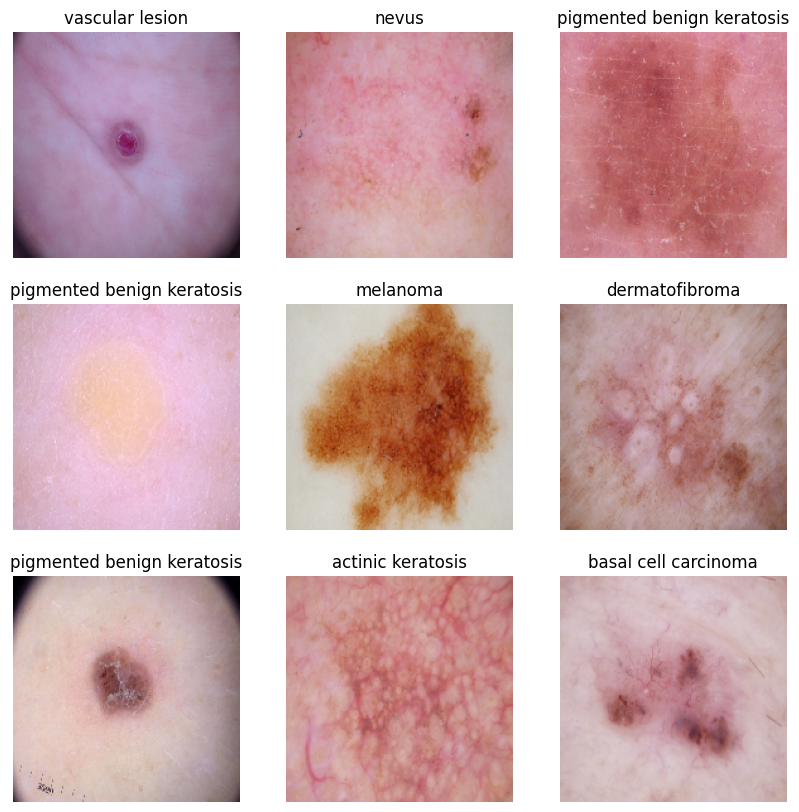

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_train_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

### Configuring the dataset for performance

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 4. Modelling

- Model 1: Basic Model
- Model 2: Basic Model + Dropout Layer + Data Augmentation
- Model 3: Basic Model + Dropout Layer + Data Augmentation + Class Balanced Dataset

### Model 1: Basic Model

In [ ]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)), # standardize values to be in the [0, 1]
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose=True
)

Epoch 1/20
56/56 [==============================] - 20s 270ms/step - loss: 2.0119 - accuracy: 0.2578 - val_loss: 1.8125 - val_accuracy: 0.3490
Epoch 2/20
56/56 [==============================] - 14s 248ms/step - loss: 1.7291 - accuracy: 0.3940 - val_loss: 1.5622 - val_accuracy: 0.4653
Epoch 3/20
56/56 [==============================] - 14s 249ms/step - loss: 1.4949 - accuracy: 0.4760 - val_loss: 1.5077 - val_accuracy: 0.4922
Epoch 4/20
56/56 [==============================] - 14s 247ms/step - loss: 1.3693 - accuracy: 0.5257 - val_loss: 1.3516 - val_accuracy: 0.5414
Epoch 5/20
56/56 [==============================] - 14s 245ms/step - loss: 1.3076 - accuracy: 0.5352 - val_loss: 1.3852 - val_accuracy: 0.5213
Epoch 6/20
56/56 [==============================] - 14s 248ms/step - loss: 1.2214 - accuracy: 0.5664 - val_loss: 1.3256 - val_accuracy: 0.5660
Epoch 7/20
56/56 [==============================] - 14s 253ms/step - loss: 1.1354 - accuracy: 0.6038 - val_loss: 1.3396 - val_accuracy: 0.5280

### Analysis

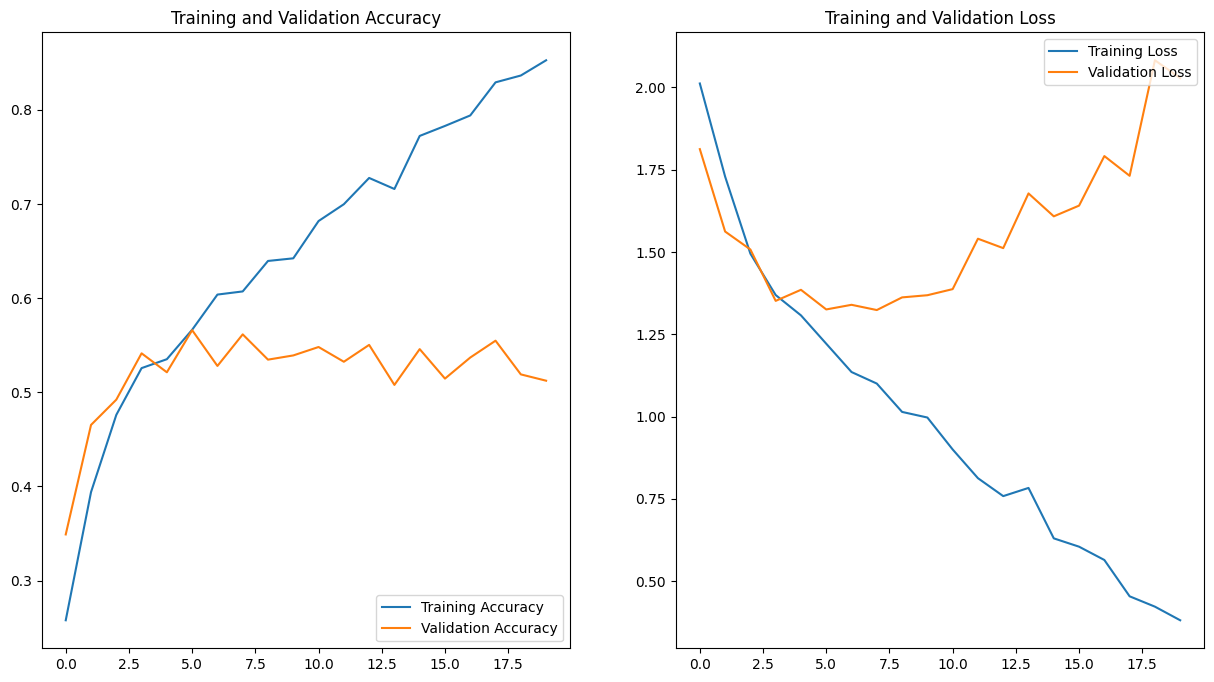

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Overfitting**
There are many ways to fight overfitting in the training process. We added dropout layers to our model and used data augmentation.

### Data augmentation with visualization

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

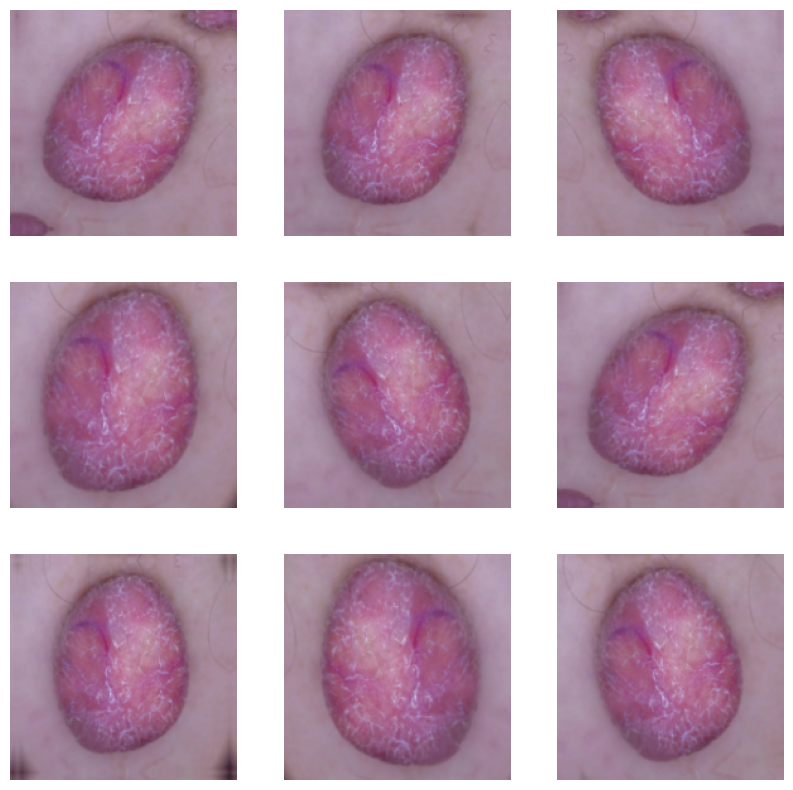

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Model 2 : Basic Model + Dropout Layers + Data Augmenting

In [ ]:
num_classes = 9

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose=True
)

Epoch 1/20
56/56 [==============================] - 18s 275ms/step - loss: 2.0157 - accuracy: 0.2483 - val_loss: 1.7923 - val_accuracy: 0.3848
Epoch 2/20
56/56 [==============================] - 15s 275ms/step - loss: 1.7120 - accuracy: 0.3811 - val_loss: 1.5602 - val_accuracy: 0.4340
Epoch 3/20
56/56 [==============================] - 15s 269ms/step - loss: 1.5691 - accuracy: 0.4397 - val_loss: 1.4600 - val_accuracy: 0.4855
Epoch 4/20
56/56 [==============================] - 15s 270ms/step - loss: 1.4791 - accuracy: 0.4855 - val_loss: 1.4414 - val_accuracy: 0.5078
Epoch 5/20
56/56 [==============================] - 15s 269ms/step - loss: 1.4091 - accuracy: 0.4989 - val_loss: 1.3867 - val_accuracy: 0.5168
Epoch 6/20
56/56 [==============================] - 15s 272ms/step - loss: 1.3955 - accuracy: 0.5078 - val_loss: 1.4016 - val_accuracy: 0.5347
Epoch 7/20
56/56 [==============================] - 15s 267ms/step - loss: 1.3099 - accuracy: 0.5452 - val_loss: 1.3797 - val_accuracy: 0.5123

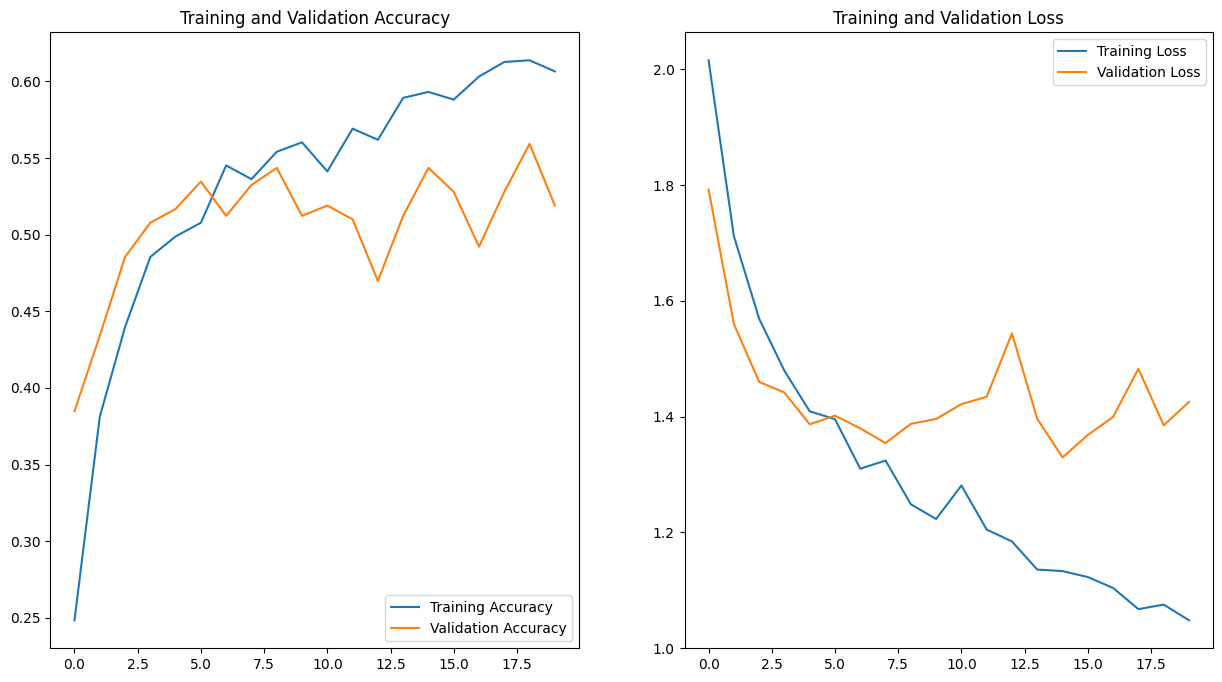

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Overfitting resolved - Model now underfitting

Distribution of Classes in the Training Dataset.

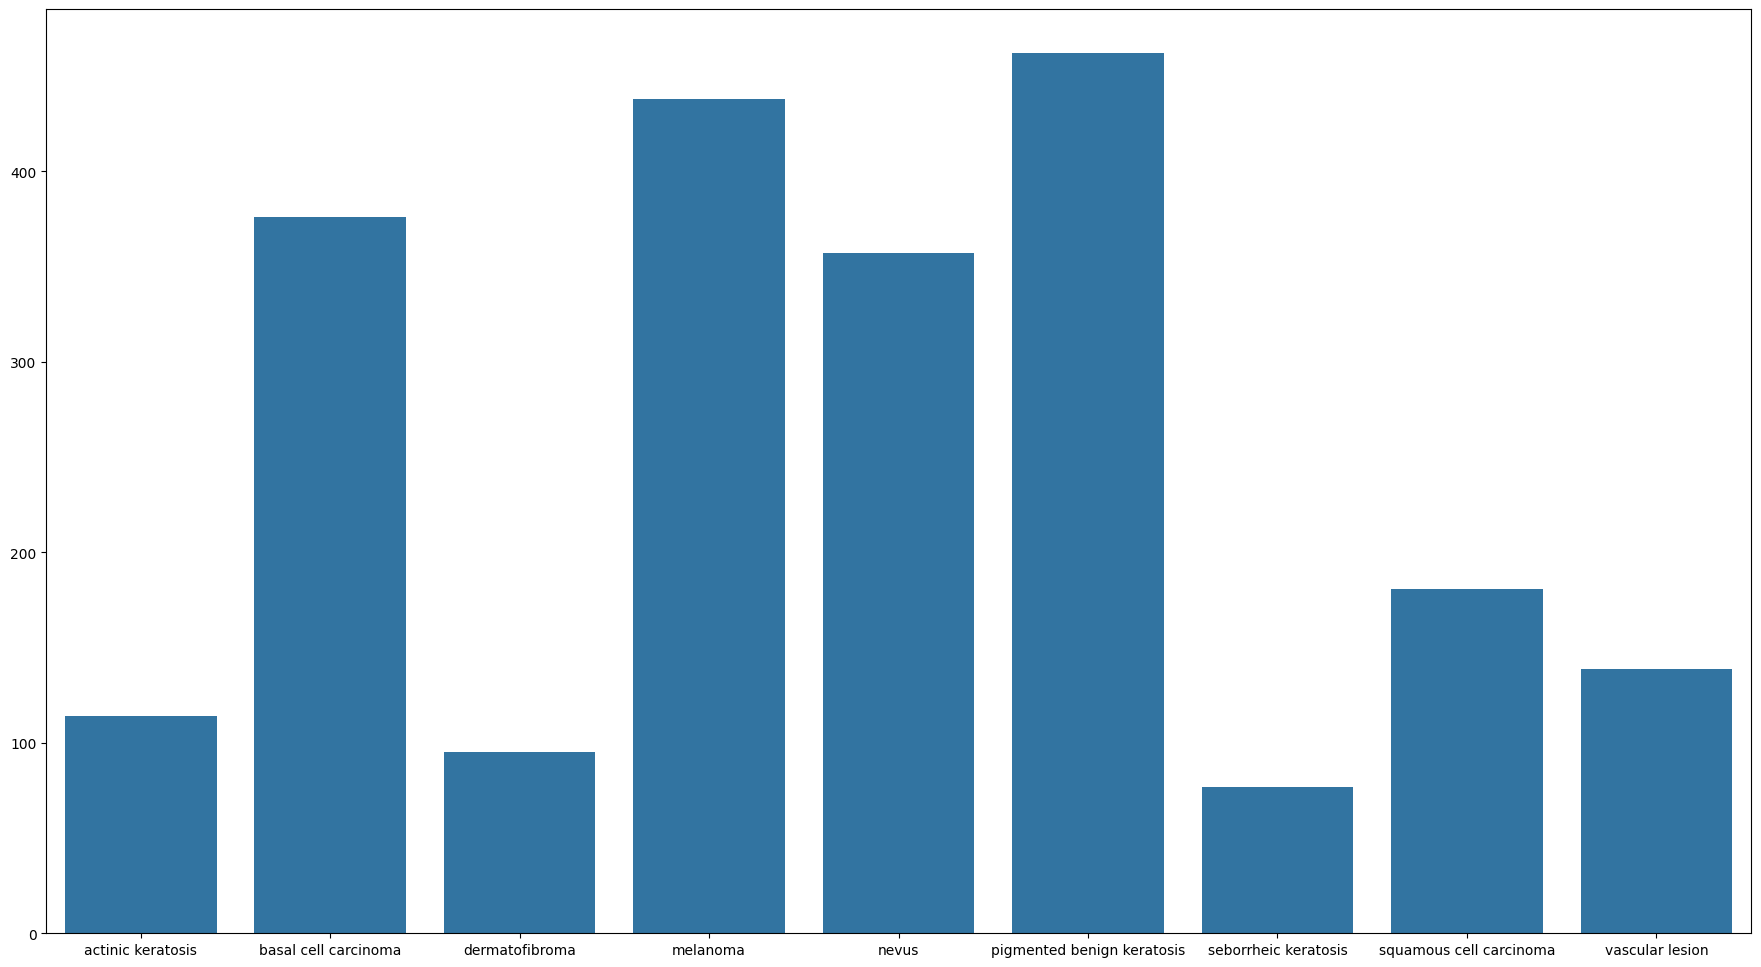

In [ ]:
class_dict_orig = {}
for i in class_names:
    class_path = pathlib.Path(path_to_training_dataset + i)
    class_count = len(list(class_path.glob('*.jpg')))
    class_dict_orig[i] = class_count

import seaborn as sns
fig, ax = plt.subplots(figsize=(22,12))
sns.barplot(x=list(class_dict_orig.keys()), y=list(class_dict_orig.values()), ax=ax)
plt.show()

In [ ]:
pd.DataFrame(list(class_dict_orig.items()),columns = ["Class Names","Number of Images"]).sort_values(by=["Number of Images"])

,Class Names,Number of Images
6,seborrheic keratosis,77
2,dermatofibroma,95
0,actinic keratosis,114
8,vascular lesion,139
7,squamous cell carcinoma,181
4,nevus,357
1,basal cell carcinoma,376
3,melanoma,438
5,pigmented benign keratosis,462


Problem with class imbalance - rectifying with Augmentor (Data augmentation package)

**Class with lowest Data is "seborrheic keratosis" with 77 images**

**Class with Highest Data is "pigmented benign keratosis" with 462 Images**

In [ ]:
import Augmentor

train_base_dir = path_to_training_dataset.split('Train')[0]
new_train_dir = train_base_dir + "Train_class_balanced/"
shutil.copytree(path_to_training_dataset,new_train_dir)
for i in class_names:
    print(path_to_training_dataset + i)
    p = Augmentor.Pipeline(path_to_training_dataset + i, new_train_dir+i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

/home/mkozul/Train/actinic keratosis
Initialised with 114 image(s) found.
Output directory set to /home/mkozul/Train_class_balanced/actinic keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD380645450>: 100%|█| 500/500 [00:02<00:00, 211.78 Samples/s


/home/mkozul/Train/basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to /home/mkozul/Train_class_balanced/basal cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD470BD03D0>: 100%|█| 500/500 [00:02<00:00, 209.12 Samples/s


/home/mkozul/Train/dermatofibroma
Initialised with 95 image(s) found.
Output directory set to /home/mkozul/Train_class_balanced/dermatofibroma.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD470BB8490>: 100%|█| 500/500 [00:02<00:00


/home/mkozul/Train/melanoma
Initialised with 438 image(s) found.
Output directory set to /home/mkozul/Train_class_balanced/melanoma.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FD470BC6290>: 100%|█| 500/500 [00:10<00:00, 49.22 Samples/s


/home/mkozul/Train/nevus
Initialised with 357 image(s) found.
Output directory set to /home/mkozul/Train_class_balanced/nevus.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7FD3A0293810>: 100%|█| 500/500 [00:08<00:00, 58.71 Samples/


/home/mkozul/Train/pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to /home/mkozul/Train_class_balanced/pigmented benign keratosis.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD3806B4090>: 100%|█| 500/500 [00:01<00:00


/home/mkozul/Train/seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to /home/mkozul/Train_class_balanced/seborrheic keratosis.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FD3A0152C10>: 100%|█| 500/500 [00:04<00:0


/home/mkozul/Train/squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to /home/mkozul/Train_class_balanced/squamous cell carcinoma.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD3A013C210>: 100%|█| 500/500 [00:02<00:00


/home/mkozul/Train/vascular lesion
Initialised with 139 image(s) found.
Output directory set to /home/mkozul/Train_class_balanced/vascular lesion.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD470C7CA90>: 100%|█| 500/500 [00:02<00:00, 213.73 Samples/s


New distribution of augmented data after adding new images to the original training data.

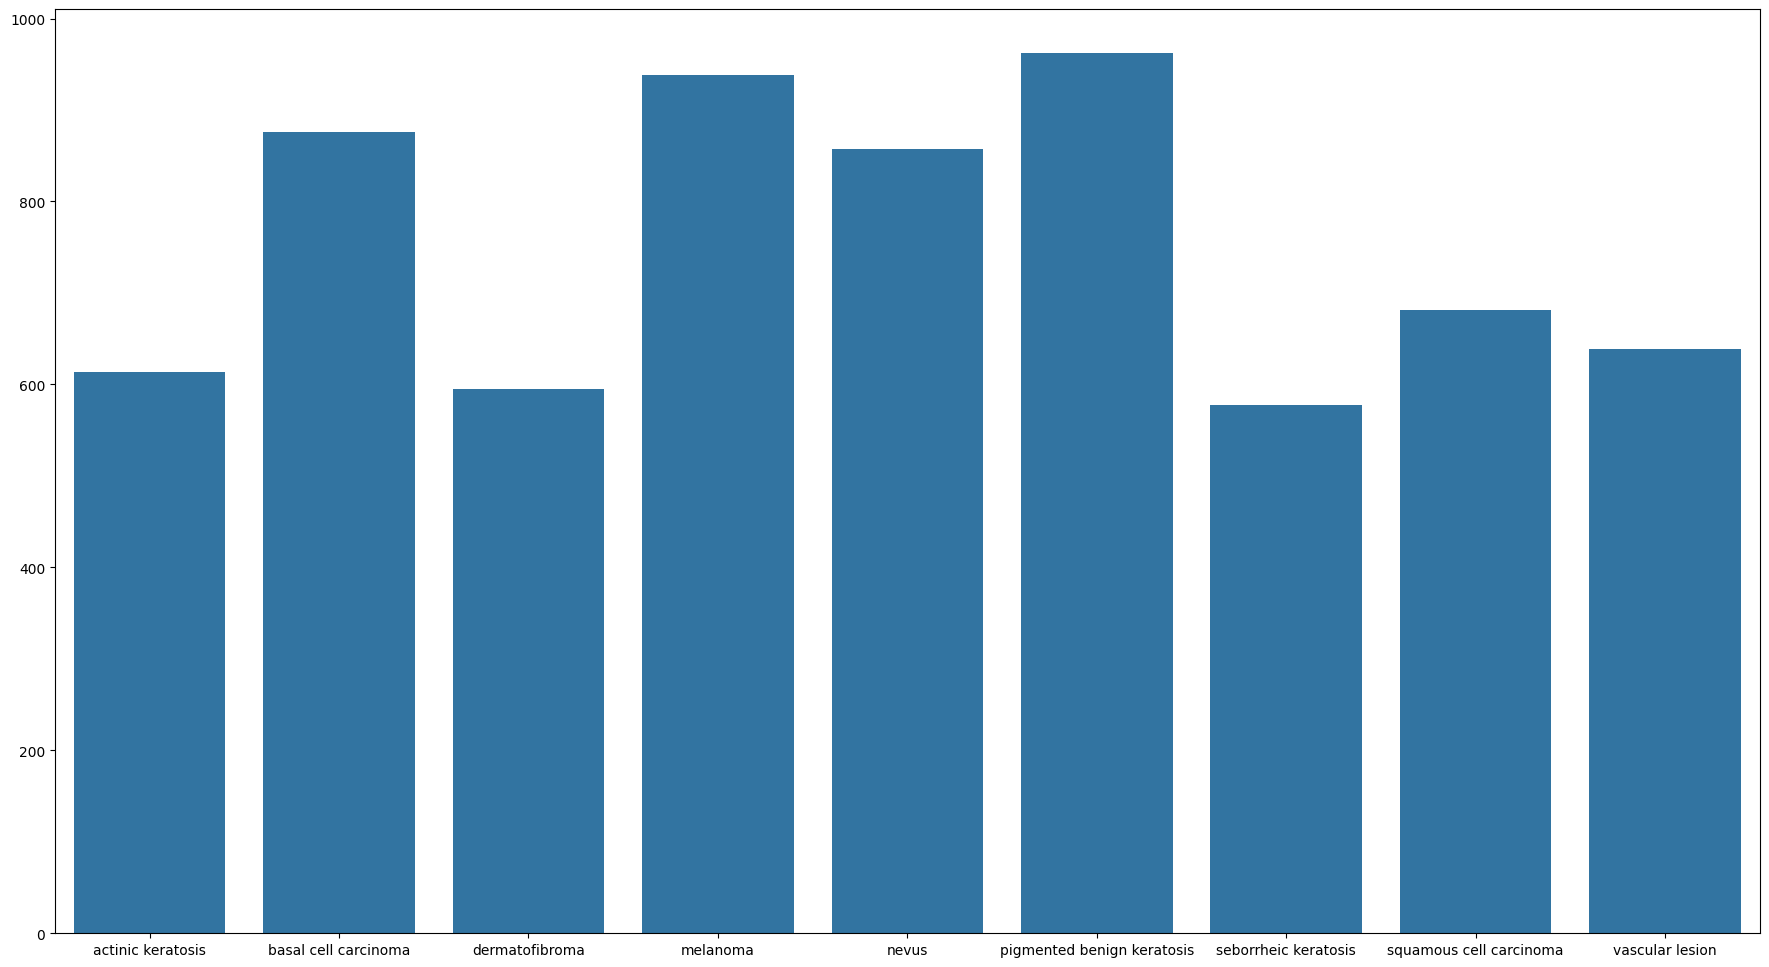

In [ ]:
class_dict_new = {}
for i in class_names:
    class_path = pathlib.Path(new_train_dir + i)
    class_count = len(list(class_path.glob('*.jpg')))
    class_dict_new[i] = class_count

import seaborn as sns
fig, ax = plt.subplots(figsize=(22,12))
sns.barplot(x=list(class_dict_new.keys()), y=list(class_dict_new.values()), ax=ax)
plt.show()

In [ ]:
pd.DataFrame(list(class_dict_new.items()),columns = ["Class Names","Number of Images"]).sort_values(by=["Number of Images"])

,Class Names,Number of Images
6,seborrheic keratosis,577
2,dermatofibroma,595
0,actinic keratosis,614
8,vascular lesion,639
7,squamous cell carcinoma,681
4,nevus,857
1,basal cell carcinoma,876
3,melanoma,938
5,pigmented benign keratosis,962


### Model 3 : Basic Model + Dropout Layer + Data Augmentation + Class Imbalance<br>

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  new_train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  new_train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
num_classes = 9

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
    verbose=True
)

Epoch 1/50
169/169 [==============================] - 50s 282ms/step - loss: 1.8834 - accuracy: 0.2652 - val_loss: 1.6272 - val_accuracy: 0.3875
Epoch 2/50
169/169 [==============================] - 47s 277ms/step - loss: 1.5535 - accuracy: 0.4017 - val_loss: 1.4811 - val_accuracy: 0.4751
Epoch 3/50
169/169 [==============================] - 48s 283ms/step - loss: 1.4363 - accuracy: 0.4549 - val_loss: 1.3801 - val_accuracy: 0.4900
Epoch 4/50
169/169 [==============================] - 48s 283ms/step - loss: 1.3805 - accuracy: 0.4742 - val_loss: 1.3103 - val_accuracy: 0.5033
Epoch 5/50
169/169 [==============================] - 48s 280ms/step - loss: 1.2701 - accuracy: 0.5124 - val_loss: 1.2340 - val_accuracy: 0.5197
Epoch 6/50
169/169 [==============================] - 48s 281ms/step - loss: 1.2245 - accuracy: 0.5304 - val_loss: 1.3591 - val_accuracy: 0.4855
Epoch 7/50
169/169 [==============================] - 48s 280ms/step - loss: 1.1682 - accuracy: 0.5610 - val_loss: 1.3298 - val_ac

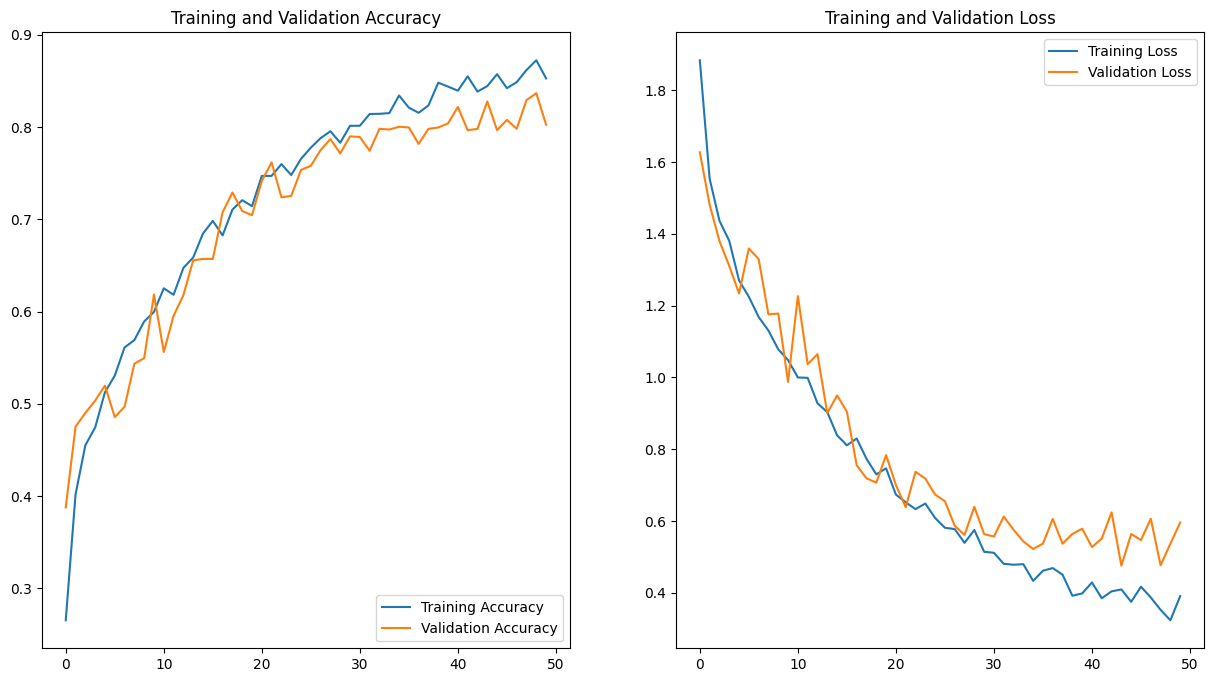

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 5. Conclusion

* Model 1: Basic Model <br>
  * Basic Model
  * No Dropout Layers
  * Small Dataset and No Augmentation
  * Model Training yeilded Non Accurate Model
  * Model was **Overfitting**
<br><br>

* Model 2: Model 1 + Dropout Layers + Data Augmentation <br>
  * Dropout Layers Added
  * Data Augmentation was added
  * Gap between Training Accuracy and Validation Accuracy decreased
  * Accuracy is still low
  * Model was **Underfitting**
<br><br>

* Model 3: Model 2 + Class balanced Dataset <br>
  * Dataset Added using Augmentor (500 images added per class) to counter class imbalance
  * Same Model 2 was used.
  * Model yeilded in 85% Training and 80% Validation Accuracy
  * This Model was both **generalizable and accurate**